In [22]:
model_name = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
import transformers
import torch
#torch.cuda.empty_cache()
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
# Free up memory
torch.cuda.empty_cache()


tokenizer = BertTokenizerFast.from_pretrained(model_name)

tokenizer.add_tokens(['[E]', '[/E]'])
print(len(tokenizer.get_vocab()))

bert = AutoModel.from_pretrained(model_name)

bert.resize_token_embeddings(len(tokenizer))
print(bert.config.vocab_size)

30524


Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30524


In [64]:
import pandas as pd
dataset_tst = pd.read_csv('/home/shovan/Phd_Prelim/PTM/Datasets/hydroxylation_test_Apr26.csv')

import re
import string
def noise_clean(sent):
    if not sent.endswith('.'):
        sent+='.'
    return sent

dataset_tst["Sentence"] = dataset_tst["Sentence"].apply(noise_clean)

In [65]:
test_labels_counts = dataset_tst['Label'].value_counts()
print("\nTest Labels Distribution:")
print(test_labels_counts)

tokens_val = tokenizer.batch_encode_plus(
    dataset_tst['Sentence'].tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(dataset_tst['Label'].tolist())

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 16

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)


Test Labels Distribution:
1    38
0    36
Name: Label, dtype: int64


/home/shovan/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [66]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert

      self.fc1 = nn.Linear(768, 256)
      self.dropout = nn.Dropout(0.1)
      self.fc2 = nn.Linear(256, 2)

      #self.sigmoid = nn.Sigmoid()
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)

      # output layer
      x = self.fc1(cls_hs)
      x = self.dropout(x)
      x = self.fc2(x)

      #x = self.sigmoid(x)
      x = self.softmax(x)

      return x

In [67]:
device = torch.device('cuda:1')

model = BERT_Arch(bert)
model = model.to(device)

model.load_state_dict(torch.load('/home/shovan/Phd_Prelim/PTM/Weights/ep10_ubiq_sumo_nedd_com_apr26.pt'))
model.eval()

import numpy as np
from sklearn.utils import class_weight

#compute the class weights
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(dataset_tst['Label']), y=dataset_tst['Label'])

print("Class Weights1:",class_weights)

# converting list of class weights to a tensor
from cProfile import label

weights= torch.tensor(class_weights,dtype=torch.float)

# push to CPU
weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

Class Weights1: [1.02777778 0.97368421]


In [68]:
def evaluate():
    print("\nEvaluating...")

    # set model to evaluation mode
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # list to hold model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to device
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [69]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
#import numpy as np


# Predict on the validation set
_, predictions = evaluate()

# Convert predictions to label indices
pred_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(dataset_tst['Label'].to_numpy(), pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(dataset_tst['Label'].to_numpy(), pred_labels, average='binary')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')


Evaluating...
Accuracy: 0.8243
Precision: 0.7778
Recall: 0.9211
F1: 0.8434


In [70]:
import numpy as np

# Assuming `dataset_tst['Sentence']` is your texts and `dataset_tst['Label']` are your true labels
true_labels = dataset_tst['Label'].to_numpy()
predicted_labels = pred_labels  # This is obtained from your code

# Find the indices where predicted and true labels differ
mismatches = np.where(predicted_labels != true_labels)[0]

# Extract the texts and their predicted and true labels for the mismatches
mismatched_texts = dataset_tst['Sentence'].iloc[mismatches].values
mismatched_predictions = predicted_labels[mismatches]
mismatched_true_labels = true_labels[mismatches]

# Display the results or process them further as needed
for i, text in enumerate(mismatched_texts):
    print(f"Text: {text}")
    print(f"Predicted Label: {mismatched_predictions[i]}, True Label: {mismatched_true_labels[i]}\n")

# Depending on your dataset size and the number of mismatches, you might want to limit the number of outputs.


Text: However, application of recombinant technology to [E]PROTEIN[/E] presents challenges, most notably the need for post-translational MODIFICATION of prolines for triple-helix stability.
Predicted Label: 1, True Label: 0

Text: Identification and characterization of [E]PROTEIN[/E]-like glycosylation and MODIFICATION of CCN1.
Predicted Label: 0, True Label: 1

Text: In this study, we detected [E]PROTEIN[/E]-like glycosylation and MODIFICATION at Lys203 of recombinant CCN1 by mass spectrometry.
Predicted Label: 0, True Label: 1

Text: To allow proper folding in triple-helices and organization in quaternary super-structures, collagen molecules require essential post-translational modifications (PTMs), including MODIFICATION of proline and lysine residues, and subsequent attachment of glycan moieties (galactose and glucose) to [E]PROTEIN[/E] on procollagen alpha chains.
Predicted Label: 1, True Label: 0

Text: To allow proper folding in triple-helices and organization in quaternary supe

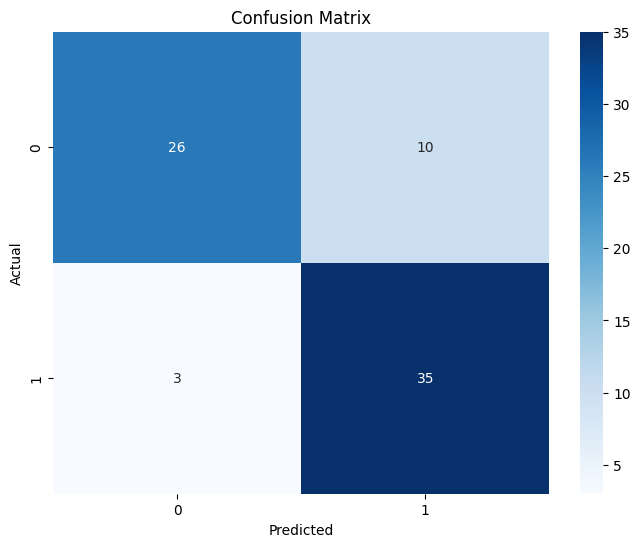

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels
true_labels = dataset_tst['Label'].to_numpy()

# Predicted labels
predicted_labels = pred_labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [11]:
def predict_sentences(sentences):
    # Tokenize the sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    # Move tensors to the correct device
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)
    
    # Predict without using named arguments
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    
    logits = outputs
    # Add a dimension to logits if it's missing the batch dimension
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
    predictions = torch.argmax(logits, dim=1)
    return predictions.cpu().numpy()



In [14]:
new_sentences = [
    "[E]p68[/E] is sumoylated",
    "[E]p68[/E] is ubiquitinated"
]

predicted_classes = predict_sentences(new_sentences)
print("Predicted classes:", predicted_classes)

Predicted classes: [1 0]
